In [1]:
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import pandas as pd
import numpy as np
import scipy.sparse
import shap
import matplotlib as plt
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import BorderlineSMOTE
import lime
from lime import lime_tabular
import statsmodels.api as sm
# from easydl import clear_output
import matplotlib.pyplot as plt
from scipy.stats import levene
from scipy.stats import f_oneway
from scipy import stats
import pingouin as pg
import forestplot as fp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# matplotlib.rcParams['axes.unicode_minus']=False
#plt.rcParams['axes.unicode_minus']=False

In [2]:
excel_file_path = 'house.xlsx'
df = pd.read_excel(excel_file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170764 entries, 0 to 170763
Data columns (total 24 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   契約_ID     170764 non-null  object        
 1   租約起日      170764 non-null  datetime64[ns]
 2   租約訖日      170764 non-null  datetime64[ns]
 3   簽約租金      170764 non-null  int64         
 4   計畫期別      170764 non-null  int64         
 5   縣市        170764 non-null  object        
 6   鄉鎮市區      169781 non-null  object        
 7   業者規模      170764 non-null  object        
 8   租約類型      170764 non-null  object        
 9   房東_ID     144037 non-null  object        
 10  出租人類型_類型  144041 non-null  object        
 11  出租人年齡     127260 non-null  float64       
 12  建物型態      144048 non-null  object        
 13  屋齡        118541 non-null  float64       
 14  幾房        117774 non-null  float64       
 15  幾廳        118416 non-null  float64       
 16  幾衛浴       118433 non-null  float64    

In [4]:
df.columns

Index(['契約_ID', '租約起日', '租約訖日', '簽約租金', '計畫期別', '縣市', '鄉鎮市區', '業者規模', '租約類型',
       '房東_ID', '出租人類型_類型', '出租人年齡', '建物型態', '屋齡', '幾房', '幾廳', '幾衛浴', '實際使用坪數',
       'X座標', 'Y座標', '房客_ID', '性別', '是否為弱勢身分', '承租人年齡'],
      dtype='object')

In [5]:
columns = ['縣市','簽約租金', '鄉鎮市區', '出租人年齡', '建物型態', '屋齡', '幾房',
           '實際使用坪數', '是否為弱勢身分', '承租人年齡']

In [6]:
df_filtered = df[columns].copy()

In [7]:
df_filtered  = df_filtered[    (df_filtered['縣市'] == "高雄市") &
    (df_filtered['承租人年齡'] >= 30) &
    (df_filtered['承租人年齡'] <= 80)]

In [8]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11519 entries, 21621 to 162985
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   縣市       11519 non-null  object 
 1   簽約租金     11519 non-null  int64  
 2   鄉鎮市區     11519 non-null  object 
 3   出租人年齡    9979 non-null   float64
 4   建物型態     10270 non-null  object 
 5   屋齡       8914 non-null   float64
 6   幾房       8903 non-null   float64
 7   實際使用坪數   8937 non-null   float64
 8   是否為弱勢身分  11519 non-null  float64
 9   承租人年齡    11519 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 989.9+ KB


In [9]:
df_filtered.dropna(inplace=True)
df_filtered.reset_index(drop=True, inplace=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8598 entries, 0 to 8597
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   縣市       8598 non-null   object 
 1   簽約租金     8598 non-null   int64  
 2   鄉鎮市區     8598 non-null   object 
 3   出租人年齡    8598 non-null   float64
 4   建物型態     8598 non-null   object 
 5   屋齡       8598 non-null   float64
 6   幾房       8598 non-null   float64
 7   實際使用坪數   8598 non-null   float64
 8   是否為弱勢身分  8598 non-null   float64
 9   承租人年齡    8598 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 671.8+ KB


In [10]:
# 篩選欄位並清除空值
df_KH = df[df['縣市']=='高雄市'].dropna()

# 轉換資料型態
df_filtered['承租人年齡'] = pd.to_numeric(df_filtered['承租人年齡'], errors='coerce')
df_KH = df_KH.dropna()

# 建立分類目標：65歲以上為1，其餘為0
df_filtered['高齡者'] = np.where(df_filtered['承租人年齡'] >= 65, 1, 0)

In [11]:
df_filtered["鄉鎮市區"]=df_filtered["鄉鎮市區"].replace({"前鎮" :"前鎮區"})

In [12]:
df_filtered["鄉鎮市區"].unique()

array(['前鎮區', '苓雅區', '鳳山區', '小港區', '三民區', '楠梓區', '前金區', '左營區', '仁武區',
       '鼓山區', '新興區', '大寮區', '鳥松區', '鹽埕區', '岡山區', '路竹區', '湖內區', '橋頭區',
       '美濃區', '大社區', '林園區', '旗山區', '茄萣區', '梓官區', '旗津區', '燕巢區', '阿蓮區',
       '大樹區', '甲仙區', '永安區', '彌陀區', '六龜區'], dtype=object)

In [13]:
excel_file_path = 'KMeans.xlsx'
df_KMeans = pd.read_excel(excel_file_path)

In [14]:
# 確保欄位名稱一致
df_clusters = df_KMeans[["行政區", "KMeans_生活型態分群"]].copy()

# 將欄位名稱改為與 df_KH 對應
df_clusters = df_clusters.rename(columns={"行政區": "鄉鎮市區"})

# 合併分群結果到 df_KH
df_filtered = df_filtered.merge(df_clusters, on="鄉鎮市區", how="left")


In [15]:
df_filtered

,縣市,簽約租金,鄉鎮市區,出租人年齡,建物型態,屋齡,幾房,實際使用坪數,是否為弱勢身分,承租人年齡,高齡者,KMeans_生活型態分群
0,高雄市,20349,前鎮區,46.0,透天厝,31.0,4.0,56.044175,0.0,50.0,0,2
1,高雄市,20009,前鎮區,49.0,透天厝,32.0,4.0,56.044175,0.0,52.0,0,2
2,高雄市,19808,前鎮區,52.0,透天厝,36.0,4.0,56.044175,0.0,56.0,0,2
3,高雄市,7990,苓雅區,59.0,公寓,36.0,4.0,26.399175,1.0,65.0,1,2
4,高雄市,9931,鳳山區,35.0,公寓,36.0,2.0,29.971700,0.0,48.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
8593,高雄市,17960,三民區,47.0,住宅大樓（十一層(含)以上有電梯）,29.0,2.0,35.177725,0.0,34.0,0,2
8594,高雄市,13002,前鎮區,65.0,公寓,36.0,3.0,26.822675,1.0,50.0,0,2
8595,高雄市,16001,楠梓區,49.0,住宅大樓（十一層(含)以上有電梯）,15.0,1.0,21.223400,1.0,41.0,0,1
8596,高雄市,17997,鳳山區,51.0,公寓,38.0,2.0,22.279125,0.0,36.0,0,2


In [16]:
df_filtered["是否電梯大樓"] = df_filtered["建物型態"].str.contains("電梯", na=False).astype(int)

In [17]:
df_filtered

,縣市,簽約租金,鄉鎮市區,出租人年齡,建物型態,屋齡,幾房,實際使用坪數,是否為弱勢身分,承租人年齡,高齡者,KMeans_生活型態分群,是否電梯大樓
0,高雄市,20349,前鎮區,46.0,透天厝,31.0,4.0,56.044175,0.0,50.0,0,2,0
1,高雄市,20009,前鎮區,49.0,透天厝,32.0,4.0,56.044175,0.0,52.0,0,2,0
2,高雄市,19808,前鎮區,52.0,透天厝,36.0,4.0,56.044175,0.0,56.0,0,2,0
3,高雄市,7990,苓雅區,59.0,公寓,36.0,4.0,26.399175,1.0,65.0,1,2,0
4,高雄市,9931,鳳山區,35.0,公寓,36.0,2.0,29.971700,0.0,48.0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8593,高雄市,17960,三民區,47.0,住宅大樓（十一層(含)以上有電梯）,29.0,2.0,35.177725,0.0,34.0,0,2,1
8594,高雄市,13002,前鎮區,65.0,公寓,36.0,3.0,26.822675,1.0,50.0,0,2,0
8595,高雄市,16001,楠梓區,49.0,住宅大樓（十一層(含)以上有電梯）,15.0,1.0,21.223400,1.0,41.0,0,1,1
8596,高雄市,17997,鳳山區,51.0,公寓,38.0,2.0,22.279125,0.0,36.0,0,2,0


In [18]:
#轉存excel
file_name = "data_clearned.xlsx"
# saving the excelsheet
df_filtered.to_excel(file_name)

In [19]:
##看高齡者在弱勢族群中的比例

In [20]:
# 篩選高齡者
df_elder = df_filtered[df_filtered["高齡者"] == 1]

# 計算比例
ratio = df_elder["是否為弱勢身分"].mean()

print(f"高齡者中弱勢族群比例：{ratio:.2%}")


高齡者中弱勢族群比例：75.12%


In [21]:
count =df_elder["是否為弱勢身分"].sum()
count

326.0

In [22]:
###

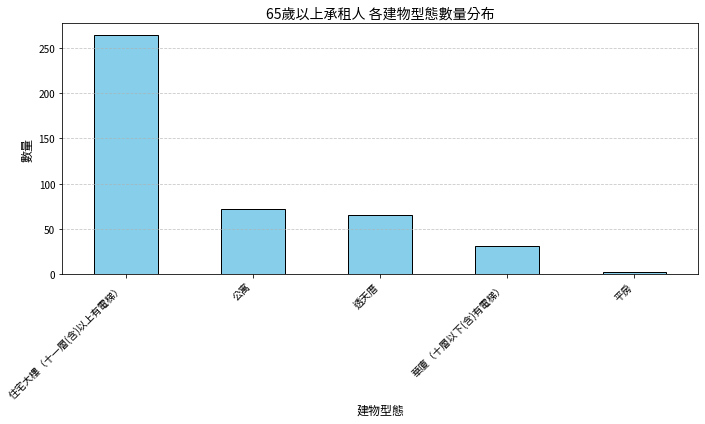

In [23]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 載入剛剛下載的字體
font_prop = fm.FontProperties(fname='SourceHanSansTC-Regular.otf')

# 篩選 65 歲以上承租人
df_65up = df_filtered[df_filtered['承租人年齡'] >= 65]
building_counts = df_65up['建物型態'].value_counts()

# 繪圖
plt.figure(figsize=(10, 6))
building_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('65歲以上承租人 各建物型態數量分布', fontproperties=font_prop, fontsize=14)
plt.xlabel('建物型態', fontproperties=font_prop, fontsize=12)
plt.ylabel('數量', fontproperties=font_prop, fontsize=12)
plt.xticks(rotation=45, ha='right', fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [24]:
###尋找屋齡切分點

基本統計：
 count    8598.000000
mean       28.949291
std        10.163019
min         4.000000
25%        23.000000
50%        30.000000
75%        37.000000
max        55.000000
Name: 屋齡, dtype: float64

分位數：
       quantile
0.00       4.0
0.05      10.0
0.10      12.0
0.25      23.0
0.50      30.0
0.75      37.0
0.90      41.0
0.95      43.0
0.99      48.0
1.00      55.0

IQR=14.00，常用極端值界限：<2.00 或 >58.00


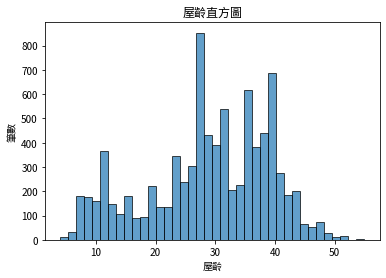


【候選A：三等分】切點≈ 26, 35
【候選B：等寬】切點≈ 21, 38
【候選C：領域】切點：5、20（例：<=5、6–20、>20）

各段筆數：
屋齡_三段
低屋齡    2922
中屋齡    2920
高屋齡    2756
Name: count, dtype: int64


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
# --------- 字型（思源黑體繁體，避免中文亂碼） ---------
font_url = 'https://github.com/adobe-fonts/source-han-sans/raw/release/OTF/TraditionalChinese/SourceHanSansTC-Regular.otf'
font_path = 'SourceHanSansTC-Regular.otf'
if not os.path.exists(font_path):
    print("正在下載字體...")
    urllib.request.urlretrieve(font_url, font_path)
    print("字體下載完成！")
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
rcParams['font.family'] = font_prop.get_name()
# 1) 清理與基本分布
s = pd.to_numeric(df_filtered["屋齡"], errors="coerce").dropna()
print("基本統計：\n", s.describe())

qs = s.quantile([0, .05, .10, .25, .50, .75, .90, .95, .99, 1.0]).to_frame("quantile")
print("\n分位數：\n", qs)

# IQR 與極端值範圍（了解是否有長尾）
q1, q3 = s.quantile([.25, .75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
print(f"\nIQR={iqr:.2f}，常用極端值界限：<{lower:.2f} 或 >{upper:.2f}")

# 2) 直方圖（Freedman–Diaconis 推薦箱數）
bin_width = 2 * iqr / (len(s) ** (1/3)) if iqr > 0 else None
n_bins = int(np.ceil((s.max() - s.min()) / bin_width)) if bin_width and bin_width > 0 else 30

plt.figure()
plt.hist(s, bins=max(n_bins, 10), edgecolor="black", alpha=0.7)
plt.title("屋齡直方圖")
plt.xlabel("屋齡")
plt.ylabel("筆數")
# 存到當前路徑
plt.savefig("屋齡值方圖.png", dpi=300, bbox_inches="tight")
plt.show()

# 3) 三種切法候選（先列出切點，最後再挑一種用）

# 3a. 分位數三等分（以 33% 與 67% 為切點）
q33, q67 = s.quantile([1/3, 2/3])
print(f"\n【候選A：三等分】切點≈ {q33:.0f}, {q67:.0f}")

# 3b. 等寬三等分（最小-最大區間平均分成三段）
w = (s.max() - s.min()) / 3
b1, b2 = s.min() + w, s.min() + 2*w
print(f"【候選B：等寬】切點≈ {b1:.0f}, {b2:.0f}")

# 3c. 領域知識切點（範例：<=5、6~20、>20）
print("【候選C：領域】切點：5、20（例：<=5、6–20、>20）")

# 4) 依你選定的切點進行分段（以下示例用候選A）
bins = [-np.inf, q33, q67, np.inf]
labels = ["低屋齡", "中屋齡", "高屋齡"]
df_filtered["屋齡_三段"] = pd.cut(s, bins=bins, labels=labels, include_lowest=True)

print("\n各段筆數：")
print(df_filtered["屋齡_三段"].value_counts(dropna=False))


In [26]:
import numpy as np
import pandas as pd

# 取出並轉為數值（非數值轉為 NaN）
s = pd.to_numeric(df_filtered["屋齡"], errors="coerce")
df_out = df_filtered.copy()

# -------------------------
# 方法一：分位數三等分（qcut）
# -------------------------
labels_q = ["低屋齡", "中屋齡", "高屋齡"]

# 先取得實際切點（便於檢視）
# duplicates='drop' 可避免大量重複值導致分位數重疊報錯
_, bins_q = pd.qcut(s.dropna(), q=3, retbins=True, duplicates="drop")
print("【分位數三等分】切點：", np.round(bins_q, 2))

# 實際分段（若仍遇到切點重疊，改用 33%/67% 後備方案）
try:
    df_out["屋齡_三段_分位數"] = pd.qcut(s, q=3, labels=labels_q, duplicates="drop")
except ValueError:
    q33, q67 = s.quantile([1/3, 2/3])
    bins_fallback = [-np.inf, q33, q67, np.inf]
    print("【分位數三等分】使用後備切點：", np.round(bins_fallback, 2))
    df_out["屋齡_三段_分位數"] = pd.cut(s, bins=bins_fallback, labels=labels_q, include_lowest=True)

print("【分位數三等分】各段筆數：")
print(df_out["屋齡_三段_分位數"].value_counts(dropna=False).sort_index())
print()

# -------------------------
# 方法二：等寬三等分（cut）
# -------------------------
labels_w = ["低屋齡", "中屋齡", "高屋齡"]
cats_w, bins_w = pd.cut(s.dropna(), bins=3, retbins=True, include_lowest=True)
print("【等寬三等分】切點：", np.round(bins_w, 2))

df_out["屋齡_三等分_等寬"] = pd.cut(s, bins=3, labels=labels_w, include_lowest=True)
print("【等寬三等分】各段筆數：")
print(df_out["屋齡_三等分_等寬"].value_counts(dropna=False).sort_index())
print()

# -------------------------
# 方法三：領域知識切點（<=5、6–20、>20）
# -------------------------
bins_d = [-np.inf, 5, 20, np.inf]
labels_d = ["<=5年", "6–20年", ">20年"]
print("【領域切點】切點：", bins_d)

df_out["屋齡_三段_領域"] = pd.cut(s, bins=bins_d, labels=labels_d, include_lowest=True, right=True)
print("【領域切點】各段筆數：")
print(df_out["屋齡_三段_領域"].value_counts(dropna=False).sort_index())

# df_out 即為輸出（含三種分段結果）


【分位數三等分】切點： [ 4. 26. 35. 55.]
【分位數三等分】各段筆數：
屋齡_三段_分位數
低屋齡    2922
中屋齡    2920
高屋齡    2756
Name: count, dtype: int64

【等寬三等分】切點： [ 3.95 21.   38.   55.  ]
【等寬三等分】各段筆數：
屋齡_三等分_等寬
低屋齡    1899
中屋齡    5106
高屋齡    1593
Name: count, dtype: int64

【領域切點】切點： [-inf, 5, 20, inf]
【領域切點】各段筆數：
屋齡_三段_領域
<=5年       10
6–20年    1754
>20年     6834
Name: count, dtype: int64


In [27]:
def explain_bins(bins, labels, right=True, include_lowest=True, name=""):
    print(f"【{name}】")
    for i in range(len(bins) - 1):
        left, right_edge = bins[i], bins[i+1]
        if i == 0 and include_lowest:
            left_bracket = "["
        else:
            left_bracket = "("
        # 預設右邊有包含
        right_bracket = "]"
        print(f"  {labels[i]}: {left_bracket}{left:.2f}, {right_edge:.2f}{right_bracket}")
    print()

# 套用到你的三種方法（用你已經算出的 bins_* 與 labels_*）
explain_bins(bins_q, labels_q, name="分位數三等分")
explain_bins(bins_w, labels_w, name="等寬三等分")
explain_bins([-np.inf, 5, 20, np.inf], ["<=5年", "6–20年", ">20年"], name="領域切點")


【分位數三等分】
  低屋齡: [4.00, 26.00]
  中屋齡: (26.00, 35.00]
  高屋齡: (35.00, 55.00]

【等寬三等分】
  低屋齡: [3.95, 21.00]
  中屋齡: (21.00, 38.00]
  高屋齡: (38.00, 55.00]

【領域切點】
  <=5年: [-inf, 5.00]
  6–20年: (5.00, 20.00]
  >20年: (20.00, inf]

